количество элементов: 153600
cpu time 1.5526316165924072
gpu time 0.30515432357788086
ускорение 5.0880210327288635

количество элементов: 480000
cpu time 4.908632278442383
gpu time 0.0009088516235351562
ускорение 5400.917103882476

количество элементов: 983040
cpu time 10.268401622772217
gpu time 0.0017161369323730469
ускорение 5983.4395665462625

количество элементов: 24000000
cpu time 249.02591466903687
gpu time 0.01624131202697754
ускорение 15332.869306087698



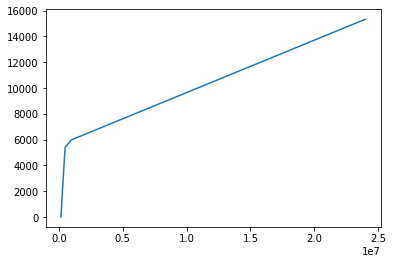

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
from numba import cuda
import math
from time import time
from PIL import Image

def add_salt_and_pepper(gb, prob):
  rnd = np.random.rand(gb.shape[0], gb.shape[1])
  noisy = gb.copy()
  noisy[rnd < prob] = 0
  noisy[rnd > 1 - prob] = 255
  return noisy


def median_filter(a):
  b = a.copy()
  start = time()
  for i in range(2, len(a)-1):
    for j in range(2, len(a[i])-1):
      t=[0, 0, 0, 0, 0, 0, 0, 0, 0]
      t[0], t[1], t[2], t[3], t[4], t[5], t[6], t[7], t[8] = a[i-1][j-1], a[i-1][j], a[i-1][j+1], a[i][j-1], a[i][j], a[i][j+1], a[i+1][j-1], a[i+1][j], a[i+1][j+1]
      for k in range(8):
        for l in range(8-k):
          if t[l]>t[l+1]:
            t[l], t[l+1] = t[l+1], t[l]
      b[i][j]=t[(int)(len(t)/2)]
  return b, time()-start

@cuda.jit
def gpu_median_filter(a, b):
  i, j = cuda.grid(2)
  t=cuda.local.array(shape=9, dtype=numba.int64)
  t[0], t[1], t[2], t[3], t[4], t[5], t[6], t[7], t[8] = a[i-1][j-1], a[i-1][j], a[i-1][j+1], a[i][j-1], a[i][j], a[i][j+1], a[i+1][j-1], a[i+1][j], a[i+1][j+1]
  for k in range(8):
    for l in range(8-k):
      if t[l]>t[l+1]:
        t[l], t[l+1] = t[l+1], t[l]
  b[i][j]=t[(int)(len(t)/2)]
    
def prepare_and_exec_gpu(a):
  b = a.copy()
  tread_number_block = 32

  a_global = cuda.to_device(a)
  b_global = cuda.to_device(b)
    
  threadsperblock = (tread_number_block, tread_number_block)
  blockspergrid_x = int(math.ceil(a.shape[0] / threadsperblock[1]))
  blockspergrid_y = int(math.ceil(b.shape[1] / threadsperblock[0]))
  blockspergrid = (blockspergrid_x, blockspergrid_y)

  start = time()
  gpu_median_filter[blockspergrid, threadsperblock](a_global, b_global)
  return b_global.copy_to_host(), time()-start 

def experiment(img_name, need_draw):
  im=(Image.open(img_name)).convert('L')
  if need_draw==True:
    display(im)
  img = np.array(im)

  img = add_salt_and_pepper(img, 0.09)
  if need_draw==True:
    display(Image.fromarray(np.uint8(img)))

  img2, ctime = median_filter(img)
  if need_draw==True:
    display(Image.fromarray(np.uint8(img2)))

  img2, gtime = prepare_and_exec_gpu(img)
  if need_draw==True:
    display(Image.fromarray(np.uint8(img2)))
  
  n=len(img)*len(img[0])
  print('количество элементов:', n)
  print('cpu time', ctime)
  print('gpu time', gtime)
  print('ускорение', ctime/gtime)
  print()
  return ctime/gtime, n

a1, n1 = experiment('img1.jpg', False)
a2, n2 = experiment('img2.jpg', False)
a3, n3 = experiment('img3.jpg', False)
a4, n4 = experiment('img4.jpg', False)

plt.plot([n1, n2, n3, n4], [a1, a2, a3, a4])
plt.show()

